# Problem Statement -II 

********************************

    ** Develop a model to predict Body Mass Index (BMI). 
    As independent predictor variables Use the **demographic data** from the previous part of the test. Focus on the interpretability of your findings as well model performance. 
    The target variable for this problem can be found in the file ‘BMX_I.csv’. 
    You may choose the form &/or algorithm(s) for presenting the model’s interpretation or explanation as you deem appropriate.

    1. ** Data Preparation **
        a. Null Check
        b. Zero Variance Check
        c. Duplicate Check
        d. Quasi Variance Check
        
    2. ** EDA **
        a. Observation basic Bi-variate analysis , Corr analysis
        
    3. ** Feature Engineering **
        a. Basic Feature Transformation 
        b. 3-degree Polynomial Transformation
        c. Feature selection based on general understanding
        
    4. ** Model Development & Validation **
        a. Linear Regression
        b. Random Forest Regression
        b. LGBM Regression
    5.  Hyper Parameter tuning and Final model
    
    6. ** Model Interpretation
        a. Feature Importance/Ranking
        

# Import Libraries

In [1]:
import os
import glob
import time
import math
import warnings
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
import matplotlib.cm as cm
import dask.dataframe as dd
import matplotlib.pyplot as plt
from multiprocessing import Pool
import matplotlib.lines as mlines
from mpl_toolkits.mplot3d import Axes3D
import statsmodels.api as sm 

## Model & Preprocessing Libraries

In [2]:
import gc
import shap
import ppscore as pps
import lightgbm as lgb
import missingno as msno
from sklearn import metrics
import category_encoders as ce
from hyperopt import Trials,hp, tpe
from hyperopt.fmin import fmin
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import make_scorer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import cross_val_score, StratifiedKFold, learning_curve, cross_validate

# Display Settings 

In [3]:
sns.set(style="whitegrid", color_codes=True)
%matplotlib inline
warnings.filterwarnings("ignore")
pd.set_option('max_colwidth', 999)
pd.set_option('display.max_columns', 999)
pd.set_option("display.max_rows", 999)

#### Custom Functions

In [4]:
def quantitative_summarized(dataframe, x=None, y=None, hue=None, palette='Set1', ax=None, verbose=True, swarm=False):
    '''
    Helper function that gives a quick summary of quantattive data
    Arguments
    =========
    dataframe: pandas dataframe
    x: str. horizontal axis to plot the labels of categorical data (usually the target variable)
    y: str. vertical axis to plot the quantitative data
    hue: str. if you want to compare it another categorical variable (usually the target variable if x is another variable)
    palette: array-like. Colour of the plot
    swarm: if swarm is set to True, a swarm plot would be overlayed
    Returns
    =======
    Quick Stats of the data and also the box plot of the distribution
    '''
    print("**************************************************")
    print("Feature name:",x)
    print("Target name:",y)
    print("**************************************************")
    print("Group by count:\n",dataframe[x].value_counts())
    print("**************************************************")
    print("Group by Mean:\n",dataframe.groupby(x)[y].mean())
    print("**************************************************")
    series = dataframe[y]
#     print(series.describe())
#    print('mode: ', series.mode())
    if verbose:
        print('='*80)
        print(series.value_counts())

    sns.boxplot(x=x, y=y, hue=hue, data=dataframe, palette=palette, ax=ax)

    if swarm:
        sns.boxplot(x=x, y=y, hue=hue, data=dataframe,
                      palette=palette, ax=ax)

    plt.show()

# Load Data 

    ** As we have to use the Demographic data for predicting the BMI for the person. I will be using the pre-processed data from my problem statement-I.
    I will be joining it with BMI dataframe and extract the required column

In [5]:
demo_df = pd.read_csv("demo_df.csv")
bmi_df = pd.read_csv("BMX_I.csv")
print("Demo_df Shape",demo_df.shape)
print("Bmi_df Shape",bmi_df.shape)
DEMO_I = pd.read_csv("DEMO_I.csv")
merged_df = pd.merge(demo_df,bmi_df[['SEQN','BMXWT','BMXHT','BMXBMI']],how='inner',left_on='SEQN',right_on='SEQN')
print("merged_df shape",merged_df.shape)
demo_columns = ["SEQN","INDFMPIR","INDFMIN2"]

Demo_df Shape (8966, 42)
Bmi_df Shape (9544, 26)
merged_df shape (8966, 45)


In [6]:
bmi_data = pd.merge(merged_df,DEMO_I[demo_columns],how='inner',left_on='SEQN',right_on='SEQN')

In [7]:
del demo_df,bmi_df,DEMO_I

# Intial analysis and Data Prep.

******************************

## Missing Values || Null Check 

In [8]:
((bmi_data.isnull().sum()/bmi_data.shape[0])*100).sort_values(ascending=False)[:5]

BMXBMI      8.387241
BMXHT       8.253402
INDFMPIR    6.981932
BMXWT       1.037252
INDFMIN2    0.000000
dtype: float64

    ** As we can see the missing values exist in the BMX-Height || BMX-Weight and BMX-BMI columns in which BMX-BMI column is the target column.
    Initally, I was thinking to use BMX-Ht and BMX-Wt to preform the missing value imputation However, it seems the missing values are equally distributed for
    BMX-BMI and BMX-HT column so, I will have to use apporach-II for treatment.
    
    ** The data which contain missing data rows will be ommited.

In [9]:
bmi_data = bmi_data[bmi_data['BMXBMI'].isnull()==False].copy()

In [10]:
((bmi_data.isnull().sum()/bmi_data.shape[0])*100).sort_values(ascending=False)[:3]

INDFMPIR    7.012418
MIAINTRP    0.000000
MIAPROXY    0.000000
dtype: float64

        ** we could see the INDFMPIR is having missing values and were no treated as part of demographic data as remove being a leakage column.So I will impute the same with -999.0

In [11]:
bmi_data['INDFMPIR'] = np.where(bmi_data['INDFMPIR'].isnull()==True,-999.0,bmi_data['INDFMPIR'])

In [12]:
((bmi_data.isnull().sum()/bmi_data.shape[0])*100).sort_values(ascending=False)[:3]

INDFMIN2    0.0
DMDEDUC3    0.0
MIALANG     0.0
dtype: float64

#### Assign datatype INT to INT-columns having FLOAT datatype

In [13]:
for c in bmi_data.columns:
    if(np.array_equal(bmi_data[c].round(7), bmi_data[c].astype(int))==True):
        bmi_data[c] = bmi_data[c].astype(int)

# Data Split 

    `** Post pre-processing is done we will split the dataframe into train and test 

In [14]:
X_train, X_test, y_train, y_test = train_test_split(bmi_data.drop(columns=['BMXBMI',"SEQN"]), bmi_data.BMXBMI,
                                                    test_size=0.2,
                                                    random_state=9)

In [15]:
print("train df shape :-",X_train.shape)
print("test df shape :-",X_test.shape)

print("train target shape :-",y_train.shape)
print("test target shape :-",y_test.shape)

train df shape :- (6571, 45)
test df shape :- (1643, 45)
train target shape :- (6571,)
test target shape :- (1643,)


## Exploratory Data Analysis

************************************************

    ** Based on my understanding thus far there would certain factors which will play pivitol role in deciding the BMI of an individual. I would consider these 
    following attributes on an individual being scrutinized for exploration and then feature engineering :
            i.   Age 
            ii.  Gender 
            iii. Ethenicity
            iv.  Ex-Army
            v.   Marital Status
            vi.  Born in US or not
            vii. Number of childern in the family.

    ** Columns associated with the above attributes are as follows :
        1. RIDAGEYR :- Age in years at screening
        2. RIDAGEMN :- Age in months at screening  0 to 24 mos
        3. RIDEXAGM :- Age in months at exam  0 to 19 years
        5. RIDEXPRG :- Pregnancy status at exam
        6. RIDRETH3 :- Race/Hispanic origin w/ NH Asian
        7. RIDRETH1 :- Race/Hispanic origin
        8. DMQMILIZ :- Served active duty in US Armed Forces
        9. DMDCITZN :- Citizenship status
        10. DMDMARTL :- Marital status
        11. DMDYRSUS :- Length of time in US
        12. DMQADFC :- Served in a foreign country
        13. INDFMPIR :- Ratio of family income to poverty
        14. INDHHIN2 :- Annual household income
        15. INDFMIN2 :- Annual family income
        16. DMDBORN4 :- Country of birth
        17. RIAGENDR :- Gender
        18. DMDHRAGE :- HH ref person's age in years
        19. RIDEXMON :- Six month time period
        20. DMDHRMAR :- HH ref person's marital status
        21. DMDHHSZA :- # of children 5 years or younger in HH
        22. DMDHHSZB :- # of children 617 years old in HH
        23. MDHHSZE :- # of adults 60 years or older in HH
        24. INDFMIN2 : - Annual family income
        25. INDHHIN2 :‑ Annual household income

In [16]:
selected_cols = list(set(["RIDAGEYR","RIDAGEMN","RIDEXAGM","RIDEXPRG","RIDRETH3","RIDRETH1","DMQMILIZ","DMDCITZN","DMDMARTL","DMDYRSUS","DMQADFC","INDFMPIR","INDHHIN2","INDFMIN2","DMDBORN4","RIAGENDR","DMDHRAGE","RIDEXMON","DMDHRMAR","DMDHHSZA","DMDHHSZB","MDHHSZE","WTMEC2YR","WTINT2YR",'INDFMIN2','INDHHIN2']))

actual_cols = []

for column in selected_cols:
    present_col = bmi_data.filter(regex=column).columns[0]
    actual_cols.append(present_col)
    
X_train = X_train[actual_cols]
X_test = X_test[actual_cols]

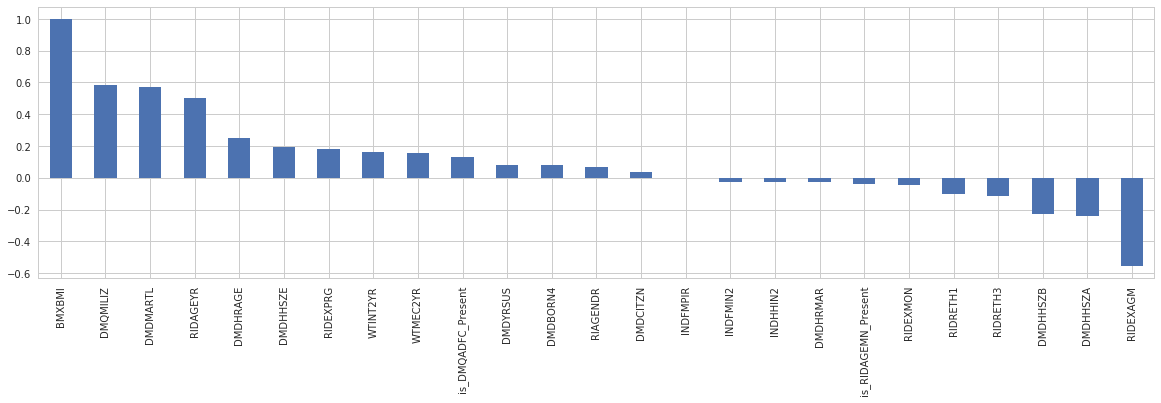

In [17]:
data = pd.concat([X_train,y_train],axis=1,copy=True,ignore_index=False)
data.apply(lambda x : x.corr(data.BMXBMI)).sort_values(ascending=False).plot(kind='bar',figsize=(20,5))

    ** As we couls see from above there many features which are highly correlated with target varibale. We will do further analysis on same.

### Numeric Data analysis

In [18]:
numeric_cols = ['DMDHRAGE','INDFMPIR','WTMEC2YR','WTINT2YR','RIDAGEYR']

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbf589d6d30>,
      dtype=object)

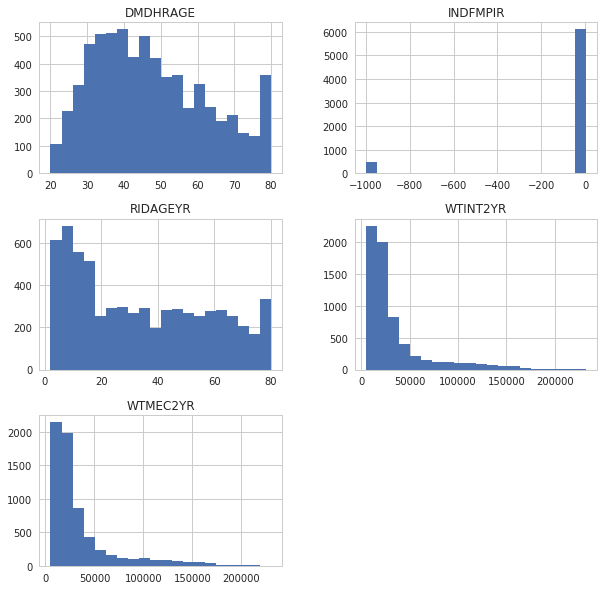

In [19]:
X_train[numeric_cols].hist(bins=20, figsize=(10, 10))

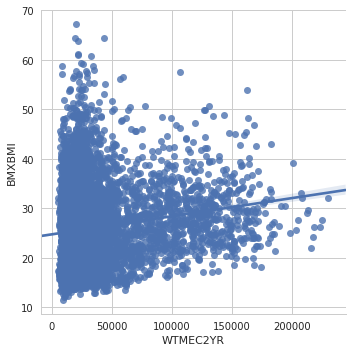

In [20]:
sns.lmplot(x='WTMEC2YR',y='BMXBMI',data=data)

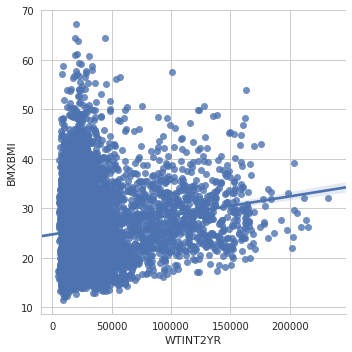

In [21]:
sns.lmplot(x='WTINT2YR',y='BMXBMI',data=data)

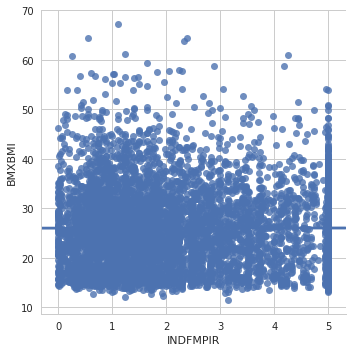

In [22]:
sns.lmplot(x='INDFMPIR',y='BMXBMI',data=data[data['INDFMPIR']>-10])

      **we will be keeping the age related data as is which are count varibales. 
      We will convert the other numeric varibales for more normality in feature engg, section.

### Categorical Feature Analysis


        **** Bivariate analysis with target variable

In [23]:
## Categorical data one hot encoding
cat_cols = ['RIDEXAGM', 'RIDEXPRG', 'RIDRETH3', 'RIDRETH1', 'DMQMILIZ', 'DMDCITZN', 'DMDMARTL',
       'DMDYRSUS', 'INDHHIN2', 'INDFMIN2', 'DMDBORN4', 'RIAGENDR', 'RIDEXMON', 'DMDHRMAR',
       'DMDHHSZA', 'DMDHHSZB', 'DMDHHSZE']

## Convert Categorical data to objects for futher analysis
for _c in cat_cols:
    X_train[_c] = X_train[_c].astype('object')
    
for _c in cat_cols:
    X_test[_c] = X_test[_c].astype('object')

**************************************************
Feature name: DMQMILIZ
Target name: BMXBMI
**************************************************
Group by count:
  2      3933
-999    2255
 1       383
Name: DMQMILIZ, dtype: int64
**************************************************
Group by Mean:
 DMQMILIZ
-999    19.535477
 1      30.272585
 2      29.350191
Name: BMXBMI, dtype: float64
**************************************************


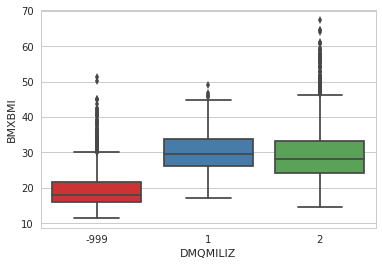

In [24]:
quantitative_summarized(dataframe= data, y = 'BMXBMI', x = 'DMQMILIZ', verbose=False, swarm=False)

**************************************************
Feature name: DMDMARTL
Target name: BMXBMI
**************************************************
Group by count:
 -999    2521
 1      2074
 5       730
 3       433
 6       387
 2       282
 4       143
 77        1
Name: DMDMARTL, dtype: int64
**************************************************
Group by Mean:
 DMDMARTL
-999    20.198612
 1      29.595950
 2      29.785461
 3      30.452887
 4      31.534965
 5      28.935205
 6      29.796641
 77     29.400000
Name: BMXBMI, dtype: float64
**************************************************


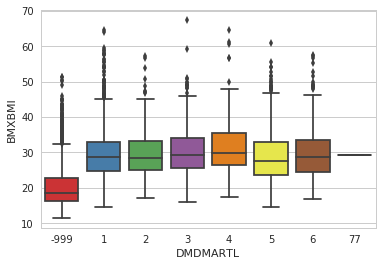

In [25]:
quantitative_summarized(dataframe= data, y = 'BMXBMI', x = 'DMDMARTL', verbose=False, swarm=False)

**************************************************
Feature name: DMDHHSZE
Target name: BMXBMI
**************************************************
Group by count:
 0    4683
1    1094
2     751
3      43
Name: DMDHHSZE, dtype: int64
**************************************************
Group by Mean:
 DMDHHSZE
0    24.999466
1    28.374314
2    28.915180
3    29.113953
Name: BMXBMI, dtype: float64
**************************************************


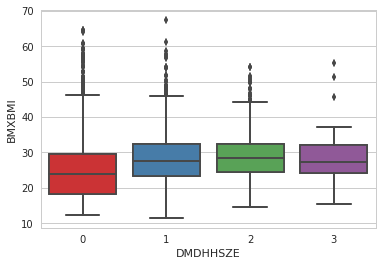

In [26]:
quantitative_summarized(dataframe= data, y = 'BMXBMI', x = 'DMDHHSZE', verbose=False, swarm=True)

**************************************************
Feature name: RIDEXPRG
Target name: BMXBMI
**************************************************
Group by count:
 -999    5643
 2       848
 1        52
 3        28
Name: RIDEXPRG, dtype: int64
**************************************************
Group by Mean:
 RIDEXPRG
-999    25.445100
 1      29.667308
 2      29.643042
 3      29.089286
Name: BMXBMI, dtype: float64
**************************************************


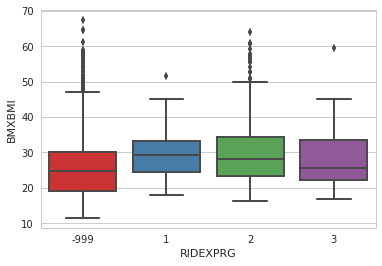

In [27]:
quantitative_summarized(dataframe= data, y = 'BMXBMI', x = 'RIDEXPRG', verbose=False, swarm=True)

**************************************************
Feature name: RIAGENDR
Target name: BMXBMI
**************************************************
Group by count:
 2    3312
1    3259
Name: RIAGENDR, dtype: int64
**************************************************
Group by Mean:
 RIAGENDR
1    25.497637
2    26.565338
Name: BMXBMI, dtype: float64
**************************************************


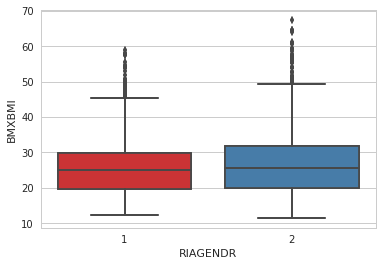

In [28]:
quantitative_summarized(dataframe= data, y = 'BMXBMI', x = 'RIAGENDR', verbose=False, swarm=True)

        **From above analysis, we could see that some of the cat. features , we could see that median and mean values across the categories are simillar while comparing the target accross independent feature categories. As many of the lE cat features are not ranked and may not work well for regression models.

In [29]:
###Count Encoding
# Create the encoder itself
target_enc = ce.CatBoostEncoder(cols=cat_cols)

# Fit the encoder using the categorical features and target
target_enc.fit(X_train[cat_cols], y_train)

# Transform the features, rename the columns with _target suffix, and join to dataframe
X_train = X_train.join(target_enc.transform(X_train[cat_cols]).add_suffix('_CB'))
X_test = X_test.join(target_enc.transform(X_test[cat_cols]).add_suffix('_CB'))

In [30]:
##exclude original cat cols
X_train.drop(columns=cat_cols, inplace=True)
X_test.drop(columns=cat_cols, inplace=True)

        **In above , I have applied catboost encoding to nullify the effect of simmilar mean for all categorical features.

In [31]:
X_train['WTINT2YR'] = np.log(X_train['WTINT2YR'])
X_train['WTMEC2YR'] = np.log(X_train['WTMEC2YR'])
X_train['INDFMPIR'] = X_train['INDFMPIR']**0.5

X_test['WTINT2YR'] = np.log(X_test['WTINT2YR'])
X_test['WTMEC2YR'] = np.log(X_test['WTMEC2YR'])
X_test['INDFMPIR'] = X_test['INDFMPIR']**0.5

        **In above , I have applied diffrent techniques for numerical variables to make them more towards normal distribution.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbf548ec8d0>,
      dtype=object)

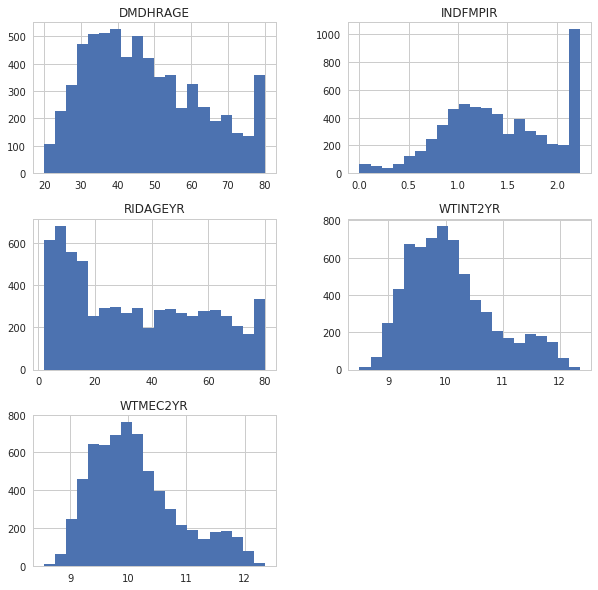

In [32]:
X_train[numeric_cols].hist(bins=20, figsize=(10, 10))

In [33]:
X_train['INDFMPIR'] = np.where(X_train['INDFMPIR'].isnull()==True,-999.0,X_train['INDFMPIR'])
X_test['INDFMPIR'] = np.where(X_test['INDFMPIR'].isnull()==True,-999.0,X_test['INDFMPIR'])

#### 2nd-order Polynomial Feature Engineering

In [34]:
poly = PolynomialFeatures(degree=2,interaction_only=True)
poly.fit(X_train)
poly_X = pd.DataFrame(poly.transform(X_train),columns=poly.get_feature_names(X_train.columns))

In [35]:
poly_X.apply(lambda x:x.corr(y_train)).sort_values(ascending = False)[:10]

RIDRETH3_CB RIAGENDR_CB    0.039881
RIDRETH1_CB RIAGENDR_CB    0.038773
RIDRETH3_CB DMDCITZN_CB    0.035295
DMDCITZN_CB RIAGENDR_CB    0.034170
RIDRETH3_CB DMDBORN4_CB    0.033807
RIDRETH1_CB DMDCITZN_CB    0.033648
RIDRETH1_CB DMDBORN4_CB    0.031565
RIDRETH3_CB                0.030703
RIDRETH3_CB RIDRETH1_CB    0.030326
RIAGENDR_CB                0.029484
dtype: float64

    ** In Above have created Interaction/polynomial(2nd order) features for adding in to data based upon checking the corr. value with target.Have chosen top 2 features based on corr value.

In [36]:
X_train['RIDRETH3_CB*RIAGENDR_CB'] = X_train.RIDRETH3_CB*X_train.RIAGENDR_CB
X_train['RIDRETH1_CB*RIAGENDR_CB'] = X_train.RIDRETH1_CB *X_train.RIAGENDR_CB
X_train['RIDRETH3_CB*DMDCITZN_CB'] = X_train.RIDRETH3_CB *X_train.DMDCITZN_CB

In [37]:
X_test['RIDRETH3_CB*RIAGENDR_CB'] = X_test.RIDRETH3_CB*X_test.RIAGENDR_CB
X_test['RIDRETH1_CB*RIAGENDR_CB'] = X_test.RIDRETH1_CB *X_test.RIAGENDR_CB
X_test['RIDRETH3_CB*DMDCITZN_CB'] = X_test.RIDRETH3_CB *X_test.DMDCITZN_CB

#### Feature Selection for Datset:-1, using corr filter

In [38]:
corr_matrix = X_train.loc[:, ~X_train.columns.isin(['tag'])].corr().abs()

upper = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]

print("No of features to drp based on corr filter-",len(to_drop))

No of features to drp based on corr filter- 8


In [39]:
X_train.drop(columns=to_drop,inplace=True)
X_test.drop(columns=to_drop,inplace=True)

In [40]:
print("Train: shape: #rows, #columns :-",X_train.shape)
print("Test: shape: #rows, #columns :-",X_test.shape)

Train: shape: #rows, #columns :- (6571, 19)
Test: shape: #rows, #columns :- (1643, 19)


## Model Building

***************************

In [41]:
kfold = 5
random_state = 9

reg_models = []
reg_models.append(LinearRegression(normalize=True,n_jobs=-1))
reg_models.append(RandomForestRegressor(random_state=random_state,
                                               max_depth=15,n_jobs=-1
                                           ))
reg_models.append(lgb.LGBMRegressor(metric="r2",
                                    num_class=1,
                                      max_depth= 15,
                                      num_leaves =15,
                                      bagging_fraction = 0.8,
                                      feature_fraction = 0.8,
                                      bagging_frequecy = 5,
                                      bagging_seed = 2020,
                                      learning_rate=0.1,
                                      random_state=random_state))

In [42]:
cv_results = []
for reg in reg_models :
    c = cross_validate(make_pipeline(reg), X_train, y_train, scoring = ['r2','neg_mean_squared_error'], cv = kfold, n_jobs=-1)
    cv_results.append(c)

cv_means_r2 = []
cv_means_mse = []

cv_std_r2 = []
cv_std_mse = []


for cv_result in cv_results:
    cv_means_r2.append(cv_result['test_r2'].mean())
    cv_std_r2.append(cv_result['test_r2'].std())
    cv_means_mse.append(cv_result['test_neg_mean_squared_error'].mean()*-1)
    cv_std_mse.append(cv_result['test_neg_mean_squared_error'].std())

cv_res = pd.DataFrame({"cv_means_R2":cv_means_r2,"cv_std_R2": cv_std_r2 ,
                       "cv_means_mse":cv_means_mse,"cv_std_mse": cv_std_mse ,
                       "Algorithm":["LinearRegression","RForest-Reg","LightGBMReg"]})

print("*********************************\nResult from Spot Check Modeling with Data\n*********************************\n")
cv_res

*********************************
Result from Spot Check Modeling with Data
*********************************



,cv_means_R2,cv_std_R2,cv_means_mse,cv_std_mse,Algorithm
0,0.444536,0.005926,35.774091,2.936215,LinearRegression
1,0.420643,0.014602,37.274945,2.689016,RForest-Reg
2,0.467371,0.008259,34.302790,2.815573,LightGBMReg


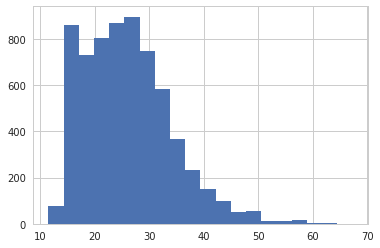

In [43]:
plt.hist(y_train,20);

         ** In above Target varibale , we could see it is left skewed , so applying log transformation for same in order to make it towards normal.

(array([  4.,  32., 181., 489., 450., 423., 495., 588., 679., 779., 714.,
        599., 459., 295., 170., 105.,  67.,  20.,  18.,   4.]),
 array([2.44234704, 2.5306877 , 2.61902836, 2.70736902, 2.79570968,
        2.88405034, 2.972391  , 3.06073166, 3.14907232, 3.23741298,
        3.32575364, 3.4140943 , 3.50243496, 3.59077562, 3.67911628,
        3.76745694, 3.8557976 , 3.94413826, 4.03247892, 4.12081958,
        4.20916024]),
 <a list of 20 Patch objects>)

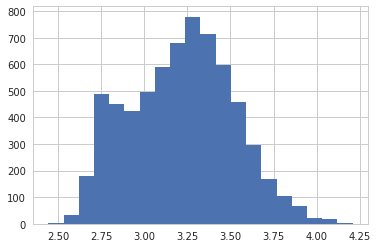

In [44]:
plt.hist(np.log(y_train),20)

In [45]:
cv_results = []
for reg in reg_models :
    c = cross_validate(make_pipeline(reg), X_train, np.log(y_train), scoring = ['r2','neg_mean_squared_error'], cv = kfold, n_jobs=-1)
    cv_results.append(c)

cv_means_r2 = []
cv_means_mse = []

cv_std_r2 = []
cv_std_mse = []


for cv_result in cv_results:
    cv_means_r2.append(cv_result['test_r2'].mean())
    cv_std_r2.append(cv_result['test_r2'].std())
    cv_means_mse.append(cv_result['test_neg_mean_squared_error'].mean()*-1)
    cv_std_mse.append(cv_result['test_neg_mean_squared_error'].std())

cv_res = pd.DataFrame({"cv_means_R2":cv_means_r2,"cv_std_R2": cv_std_r2 ,
                       "cv_means_mse":cv_means_mse,"cv_std_mse": cv_std_mse ,
                       "Algorithm":["LinearRegression","RForest-Reg","LightGBMReg"]})

print("*********************************\nResult from Spot Check Modeling with Data \n*********************************\n")
cv_res

*********************************
Result from Spot Check Modeling with Data 
*********************************



,cv_means_R2,cv_std_R2,cv_means_mse,cv_std_mse,Algorithm
0,0.542258,0.006072,0.041627,0.002046,LinearRegression
1,0.517833,0.006270,0.043870,0.002535,RForest-Reg
2,0.558636,0.004247,0.040146,0.002099,LightGBMReg


         ** After applying log transformation to target , now we could see R2 has increased almost ~8%. The Mean square has decreased due to log transformation. 

         ** As all 3 models are giving simmilar result , we will proceed with Linear Regrssion as it gives more stable and it's simple compared other bagging and boosting model. **

### Applying Recursive Feature Elimination for finding final model Linear Regression model

In [46]:
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline

In [47]:
for i in range(1, len(X_train.columns)):
    rfe = RFE(estimator=LinearRegression(normalize=True,n_jobs=-1), n_features_to_select=i)
    model = LinearRegression(normalize=True,n_jobs=-1)
    pipeline = Pipeline(steps=[('s',rfe),('zm',model)])
    # fit the model on all available data
    result = cross_validate(make_pipeline(pipeline),
                        X_train,
                        y =np.log(y_train),
                        scoring = ['r2','neg_mean_squared_error'],
                        cv = 5,
                        n_jobs=-1)
    print("No. of top features:",i,"R_Square: ",pd.DataFrame(result['test_r2']).mean().values,\
          " Mean_Square_Error: ",pd.DataFrame(result['test_neg_mean_squared_error']).mean().values*-1)

No. of top features: 1 R_Square:  [0.41034172]  Mean_Square_Error:  [0.05416283]
No. of top features: 2 R_Square:  [0.52648806]  Mean_Square_Error:  [0.04310439]
No. of top features: 3 R_Square:  [0.53598442]  Mean_Square_Error:  [0.04220547]
No. of top features: 4 R_Square:  [0.53730215]  Mean_Square_Error:  [0.04207652]
No. of top features: 5 R_Square:  [0.53779174]  Mean_Square_Error:  [0.04203175]
No. of top features: 6 R_Square:  [0.53850682]  Mean_Square_Error:  [0.0419666]
No. of top features: 7 R_Square:  [0.54000675]  Mean_Square_Error:  [0.04182979]
No. of top features: 8 R_Square:  [0.54030936]  Mean_Square_Error:  [0.04180274]
No. of top features: 9 R_Square:  [0.53984932]  Mean_Square_Error:  [0.04184163]
No. of top features: 10 R_Square:  [0.54026206]  Mean_Square_Error:  [0.04180312]
No. of top features: 11 R_Square:  [0.54098623]  Mean_Square_Error:  [0.04173915]
No. of top features: 12 R_Square:  [0.54216446]  Mean_Square_Error:  [0.04163517]
No. of top features: 13 R_

    ** From above we can see that top features can provide cummulative R2 of ~53% and then increasing with very small margin. So we can take top 5 variables and build final model and find feature importance for model interpreatation.

In [48]:
rfe = RFE(estimator=LinearRegression(normalize=True,n_jobs=-1), n_features_to_select=5)
model = LinearRegression(normalize=True,n_jobs=-1)
pipeline = Pipeline(steps=[('s',rfe),('zm',model)])
# fit the model on all available data
result = cross_validate(make_pipeline(pipeline),
                    X_train,
                    y =np.log(y_train),
                    scoring = ['r2','neg_mean_squared_error'],
                    cv = 5,
                    n_jobs=-1)


In [49]:
rfe = RFE(estimator=LinearRegression(normalize=True,n_jobs=-1), n_features_to_select=5)
model = LinearRegression(normalize=True,n_jobs=-1)
pipeline = Pipeline(steps=[('s',rfe),('zm',model)])
# fit the model on all available data
pipeline.fit(X_train, np.log(y_train))

feature_ranking = pd.DataFrame({"feature_name":X_train.columns.values,"Ranking": list(rfe.ranking_)})
X_train_new = X_train[list(feature_ranking[feature_ranking['Ranking']<2].feature_name.values)]

pipeline.fit(X_train_new, np.log(y_train))

Pipeline(memory=None,
     steps=[('s', RFE(estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=True),
  n_features_to_select=5, step=1, verbose=0)), ('zm', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=True))])

In [50]:
## Find diffrent scores on diffrent datasets:- Train , Cross Validation , Test
R_Square = []
Mean_Square_Error = []


R_Square.append(pd.DataFrame(result['train_r2']).mean().values[0])
Mean_Square_Error.append(pd.DataFrame(result['train_neg_mean_squared_error']).mean().values[0]*-1)

R_Square.append(pd.DataFrame(result['test_r2']).mean().values[0])
Mean_Square_Error.append(pd.DataFrame(result['test_neg_mean_squared_error']).mean().values[0]*-1)


## Predict on Test Data and get scores:
R_Square.append(metrics.r2_score(np.log(y_test),pipeline.predict(X_test[X_train_new.columns])))
Mean_Square_Error.append(metrics.mean_squared_error(np.log(y_test),pipeline.predict(X_test[X_train_new.columns])))

    
Score_Result = pd.DataFrame({"R_Square":R_Square,
                       "Mean_Square_Error":Mean_Square_Error,
                       "Scores":["Train Data","CVal Data","Test Data"]})

print("**********************\n Score result on final model \n**********************\n")
print(Score_Result)

**********************
 Score result on final model 
**********************

   R_Square  Mean_Square_Error      Scores
0  0.540572           0.041813  Train Data
1  0.537792           0.042032   CVal Data
2  0.495314           0.043811   Test Data


            ** As we can see from above table:-
            The R_Square, Mean Square Error scores are very near for all Train , Cross Val Data (5 fold) and test data. Which Shows the model is stable. 
            
            But overall R-square is moderate , we need some extra information (feature) to enhnace the R-square of the model. Also there are some other assumptions , could be reasearched more for linear regression, But for now the model score is stable accross all data.

## Model Interpretation through Feature Importance/Ranking

In [51]:
rfe = RFE(estimator=LinearRegression(normalize=True,n_jobs=-1), n_features_to_select=1)
model = LinearRegression(normalize=True,n_jobs=-1)
pipeline = Pipeline(steps=[('s',rfe),('zm',model)])
# fit the model on all available data
pipeline.fit(X_train_new, np.log(y_train))

Pipeline(memory=None,
     steps=[('s', RFE(estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=True),
  n_features_to_select=1, step=1, verbose=0)), ('zm', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=True))])

In [52]:
feature_ranking_final = pd.DataFrame({"feature_name":X_train_new.columns.values,"Ranking": list(rfe.ranking_)})
print(feature_ranking_final.sort_values(by=['Ranking']))

          feature_name  Ranking
2          RIDEXAGM_CB        1
3          RIDRETH3_CB        2
4          DMDBORN4_CB        3
1  is_RIDAGEMN_Present        4
0             WTMEC2YR        5


        ** As the SKlearn Linear rgeression doesn't provide feature significance (P Value) , so have calcuated the feature ranking using recusrive feature elimination method.

        As could the varibles which are impactful are:
            RIDEXAGM_CB -->  RIDEXAGM ‑ Age in months at exam ‑ 0 to 19 years
            RIDRETH3_CB -->  RIDRETH3 ‑ Race/Hispanic origin w/ NH Asian
            DMDBORN4_CB -->  DMDBORN4 ‑ Country of birth
            is_RIDAGEMN_Present --> RIDAGEMN ‑ Age in months at screening ‑ 0 to 24 mos
            WTINT2YR ‑-> Full sample 2 year interview weight

        Thus, we can see the young person's age seems to be the most import feature for predicting the HH income and intuitively it makes sense. As it will have less varinace of BMI compared older persons.
            Attributes like Country of Birth,Age is months also makes important contribution for the model to predict BMI data.